In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import healpy as hp
from healpy.newvisufunc import projview
import george
from george.modeling import Model
from scipy.optimize import minimize
import os
import sys

sys.path.insert(0, '/home/aew492/lss-dipoles')
from dipole import thetaphi_to_radec, dipole, dipole_map

#### functions

In [3]:
def plot_map(map, title=None, unit=None, projection_type='mollweide', coord=['E'], graticule=True, graticule_labels=True):
    projview(map, title=title, unit=unit, projection_type=projection_type, coord=coord,
             graticule=graticule, graticule_labels=graticule_labels)

#### healpy parameters

In [4]:
NSIDE = 16
NPIX = hp.nside2npix(NSIDE)

#### construct arrays for the fit

In [5]:
# X: selection maps: random for now
nmaps = 4
X_train_full = np.random.uniform(size=(NPIX,nmaps))

In [6]:
# y: Gaia data
data_quaia = Table.read('/scratch/aew492/quasars/catalogs/catalog_G20.0.fits', format='fits')
pix_idx = hp.ang2pix(NSIDE, data_quaia['ra'], data_quaia['dec'], lonlat=True)  # get pixel locations of each quasar
map_data = np.bincount(pix_idx, minlength=NPIX)  # bin these pixel indices to get qso number density in each pixel
y_train_full = np.copy(map_data).astype(float)

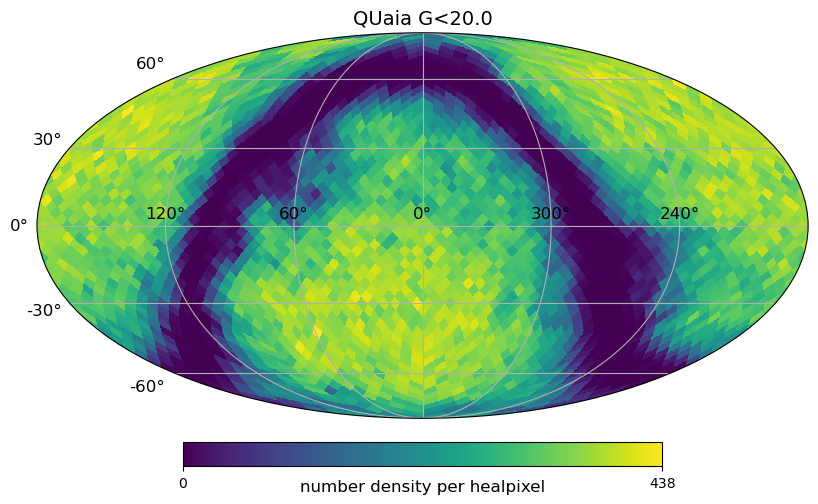

In [7]:
plot_map(y_train_full, title='QUaia G<20.0', unit='number density per healpixel')

In [8]:
# assume poisson error
y_err_train_full = np.sqrt(y_train_full)

In [9]:
# for now, can't figure out how to make this work with the dipole simply removing the zero values from the arrays;
#  so set zeros to 1/2 a star
idx_zero = (np.abs(y_train_full) == 0)
print('num zeros:', np.sum(idx_zero))
y_train_full[idx_zero] = 0.5
print('min post', np.min(y_train_full), flush=True)

num zeros: 222
min post 0.5


In [10]:
# * take only certain indices
idx = np.arange(1000)
X_train = X_train_full[idx]
y_train = y_train_full[idx]
y_err_train = y_err_train_full[idx]

In [11]:
# scale everything
X_train_scaled = X_train - np.mean(X_train, axis=0)
y_train_scaled = np.log(y_train)
y_err_train_scaled = y_err_train / y_train

In [12]:
ndim = X_train.shape[1]
nparams = X_train_scaled.shape[1]

In [13]:
X_train.shape, y_train.shape, ndim, nparams

((1000, 4), (1000,), 4, 4)

#### GP with mean function

try to make a class (modeled after DFM's example in https://george.readthedocs.io/en/latest/tutorials/model/)

In [14]:
class DipoleModel(Model):
    parameter_names = ('monopole', 'dipole_x', 'dipole_y', 'dipole_z')
    thetas, phis = hp.pix2ang(NSIDE, ipix=np.arange(NPIX))
    
    def get_value(self, X):
        return self.monopole + dipole(DipoleModel.thetas[idx], DipoleModel.phis[idx],
                                      self.dipole_x, self.dipole_y, self.dipole_z)
    
    def set_vector(self, v):
        self.monopole, self.dipole_x, self.dipole_y, self.dipole_z = v

In [15]:
# set kernel
kernel_p0 = np.exp(np.full(nparams, 0.1))
kernel = george.kernels.ExpSquaredKernel(kernel_p0, ndim=ndim)

In [16]:
# initialize GP
gp = george.GP(kernel, mean=DipoleModel(monopole=2., dipole_x=0., dipole_y=0., dipole_z=0.))

In [17]:
# test initial pars vector
print('p init:', gp.get_parameter_vector())

p init: [2.  0.  0.  0.  0.1 0.1 0.1 0.1]


In [18]:
gp.compute(X_train_scaled, y_err_train_scaled)

In [19]:
print('lnlike compute:', gp.log_likelihood(y_train_scaled))

lnlike compute: -4733756.572126447


In [20]:
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y_train_scaled)

In [21]:
def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y_train_scaled)

In [22]:
# try to minimize
result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)

In [23]:
result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2658.454270073995
        x: [ 5.579e+00 -1.544e+00 -5.899e-01 -1.259e+00 -1.040e+02
             1.111e+02 -5.286e+01  1.317e+01]
      nit: 23
      jac: [ 1.836e-08 -5.006e-06 -8.336e-06 -9.449e-06 -0.000e+00
            -0.000e+00 -0.000e+00 -0.000e+00]
 hess_inv: [[ 1.386e-02 -2.924e-04 ...  6.194e-01 -5.907e-01]
            [-2.924e-04  3.709e-03 ... -5.818e-02  7.563e-02]
            ...
            [ 6.194e-01 -5.818e-02 ...  3.709e+01 -3.159e+01]
            [-5.907e-01  7.563e-02 ... -3.159e+01  2.906e+01]]
     nfev: 28
     njev: 28

In [25]:
gp.set_parameter_vector(result.x)
print('p post op:', gp.get_parameter_vector())
print('lnlike final:', gp.log_likelihood(y_train_scaled))

p post op: [   5.57898073   -1.54430432   -0.58986117   -1.25916528 -103.97737385
  111.10820829  -52.8579038    13.17144609]
lnlike final: -2658.454270073995


In [26]:
# PREDICT
print('predict p:', gp.get_parameter_vector())
y_pred_scaled, _ = gp.predict(y_train_scaled, X_train_scaled)

predict p: [   5.57898073   -1.54430432   -0.58986117   -1.25916528 -103.97737385
  111.10820829  -52.8579038    13.17144609]


In [27]:
# un-log the map
y_unscaled = np.exp(y_pred_scaled)

In [28]:
# check out residuals
res = y_unscaled - y_train

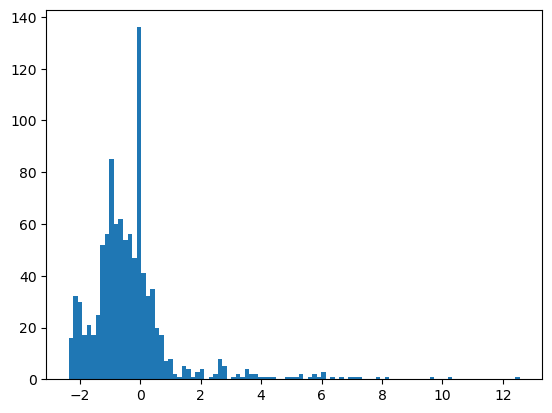

In [32]:
fig, ax = plt.subplots()
_, _, _ = a.hist(res, bins=50)
# plt.loglog()